In [1]:
import aplpy
import os
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.convolution import convolve_fft, Gaussian2DKernel
import math 
from astropy import units as u
from scipy.interpolate import UnivariateSpline
import scipy.optimize as optimize
from scipy.interpolate import interp1d
import sys
from numpy.random import rand,seed
from pylab import *
from scipy import stats
import lmfit 
from scipy.special import erf
from lmfit import Minimizer, Parameters, fit_report

In [2]:
#LOADING IN DATA FILES
after_B1_000 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/n_dens_pbcor/N_dens_feather10_B1_000_clean14_1_pbcor.fits')
before_B1_000 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/N_dens/N_dens_B1snap_000.fits')
after_B1_051 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/n_dens_pbcor/N_dens_feather10_B1_051_clean14_pbcor.fits')
before_B1_051 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/N_dens/N_dens_B1snap_051.fits')
after_B10_000 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/n_dens_pbcor/N_dens_feather10_B10_000_clean14_pbcor.fits')
before_B10_000 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/N_dens/N_dens_B10snap_000.fits')
after_B10_066 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/n_dens_pbcor/N_dens_feather10_B10_066_clean14_pbcor.fits')
before_B10_066 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/N_dens/N_dens_B10snap_066.fits')
noise_B1_000 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/flux10_noise_final/flux10_B1snap_000_clean14_1_noise_finalfwhm.fits')
noise_B1_051 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/flux10_noise_final/flux10_B1snap_051_clean14_noise_finalfwhm.fits')
noise_B10_000 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/flux10_noise_final/flux10_B10snap_000_clean14_noise_finalfwhm.fits')
noise_B10_066 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/flux10_noise_final/flux10_B10snap_066_clean14_noise_finalfwhm.fits')

In [3]:
#SIMULATED OBSERVATIONAL DATA
def simulated_data_retrieval(sim_self):
    sim_self = sim_self[0].data
    column_density_array_after = sim_self
    flat_column_density_array_after = column_density_array_after.flatten()
    return flat_column_density_array_after

In [4]:
#ORIGINAL SIMULATION DATA
def original_data_retrieval(snap_self):
    snap_self = snap_self[0].data * 10
    column_density_array_before = snap_self / (1e4)
    flat_column_density_array_before = column_density_array_before.flatten()
    return flat_column_density_array_before

In [9]:
#COMBINING THESE FUNCTIONS
def data_harvesting(before_data, after_data):
    after_data_flat_array = simulated_data_retrieval(after_data)
    before_data_flat_array = original_data_retrieval(before_data)
    return before_data_flat_array, after_data_flat_array

In [5]:
#GETTING SIGMA DATA
def sigma_retrieval(noise_file):
    sigma_data = noise_file[0].data
    flat_sigma_data = sigma_data.flatten()
    sigma_value = np.median(flat_sigma_data)
    three_sigma_value = 3 * np.median(flat_sigma_data)
    return three_sigma_value

In [6]:
#CREATING PLOTS OF DATA
def create_pdf(image_data, number_of_bins):
    image = np.log10(image_data)
    n_min = np.min(image)
    n_max = np.max(image)
    n_bins = number_of_bins
    n_total = np.count_nonzero(image)
    n_edges = np.linspace(n_min, n_max, n_bins)
    n_cens = [(a + b) /2 for a,b in zip(n_edges[:-1], n_edges[1:])]
    
    bin_width = n_edges[2] - n_edges[1]
    
    x_arr = np.array(n_cens)
    y_arr = np.zeros(n_bins)
    for i in range(n_bins -1):
        pix_in_bin_i = np.where((image>n_edges[i]) & (image<n_edges[i+1]))[0]
        y_arr[i] = np.array(np.count_nonzero(pix_in_bin_i) * ((n_total)**(-1)) * ((bin_width)**(-1)))
        
    normalization = y_arr * bin_width
    normalization_check = np.sum(normalization)
        
    return x_arr, y_arr, normalization_check

In [47]:
def plotting_pdf(image_data, number_of_bins):
    x_arr = create_pdf(image_data, number_of_bins)[0]
    y_arr = np.log10(create_pdf(image_data, number_of_bins)[1])
    plt.scatter(x_arr, y_arr[:-1])
    return x_arr, y_arr

In [48]:
data_array_before, data_array_after_all = data_harvesting(before_B1_000, after_B1_000)
data_array_after = data_array_after_all[(data_array_after_all>1e22)]
noise_data = noise_B1_000
title = 'B1 000'

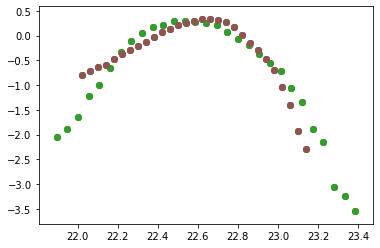

In [49]:
plotting_pdf(data_array_before, 30)
x_arr_before = plotting_pdf(data_array_before, 30)[0]
y_arr_before = plotting_pdf(data_array_before, 30)[1]
plotting_pdf(data_array_after, 30)
x_arr_after = plotting_pdf(data_array_after, 30)[0]
y_arr_after = plotting_pdf(data_array_after, 30)[1]

In [40]:
x = x_arr_before 
y = np.nan_to_num(y_arr_before[:-1])
true_sigman = 0.4
true_an = np.mean(x)
true_mun = 22
true_mp = -7
true_break = 22.9

In [42]:
#Original from Perry
def lognorm_powerlaw_func(x,an=true_an, mun=true_mun, sigman=true_sigman, mp=true_mp, pbreak=true_break):
    y = np.copy(x)
    y[np.where(x<pbreak)] = np.log10((an/(np.sqrt(2*np.pi)*sigman*x[np.where(x<pbreak)]))*np.exp(-1*(np.log(x[np.where(x<pbreak)])-mun)**2/(2*sigman**2)))
    y[np.where(x>=pbreak)] = (np.log10(x[np.where(x>=pbreak)])*mp + np.log10(((an/(np.sqrt(2*np.pi)*sigman*pbreak))*np.exp(-1*(np.log(pbreak)-mun)**2/(2*sigman**2)))) - (mp*np.log10(pbreak)))
    return y

In [58]:
#First attempt using PDF made from eq. 4
def lognorm_powerlaw_func2(x,an=true_an, mun=true_mun, sigman=true_sigman, mp=true_mp, pbreak=true_break):
    y = np.copy(x)
    y[np.where(x<pbreak)] = np.log10((an/(np.sqrt(2*np.pi)*sigman*x[np.where(x<pbreak)]))*np.exp(-1*(np.log(x[np.where(x<pbreak)])-mun)**2/(2*sigman**2)))
    y[np.where(x>=pbreak)] = ((x[np.where(x>=pbreak)])*mp + np.log10(((an/(np.sqrt(2*np.pi)*sigman*pbreak))*np.exp(-1*(np.log(pbreak)-mun)**2/(2*sigman**2)))) - (mp*np.log10(pbreak)))
    return y

In [60]:
#Attempting to modify eq. 4 to keep data out of log scale
def create_pdf2(image_data, number_of_bins):
    image = (image_data)
    n_min = np.min(image)
    n_max = np.max(image)
    n_bins = number_of_bins
    n_total = np.count_nonzero(image)
    n_edges = np.linspace(n_min, n_max, n_bins)
    n_cens = [(a + b) /2 for a,b in zip(n_edges[:-1], n_edges[1:])]
    
    bin_width = n_edges[2] - n_edges[1]
    
    x_arr = np.array(n_cens)
    y_arr = np.zeros(n_bins)
    for i in range(n_bins -1):
        pix_in_bin_i = np.where((image>n_edges[i]) & (image<n_edges[i+1]))[0]
        y_arr[i] = np.array(np.count_nonzero(pix_in_bin_i) * ((n_total)**(-1)) * ((bin_width)**(-1)))
        
    normalization = y_arr * bin_width
    normalization_check = np.sum(normalization)
        
    return x_arr, y_arr, normalization_check

In [67]:
def plotting_pdf2(image_data, number_of_bins):
    x_arr = np.log10(create_pdf2(image_data, number_of_bins)[0])
    y_arr = np.log10((create_pdf2(image_data, number_of_bins)[1]))
    plt.scatter(x_arr, y_arr[:-1])
    return x_arr, y_arr

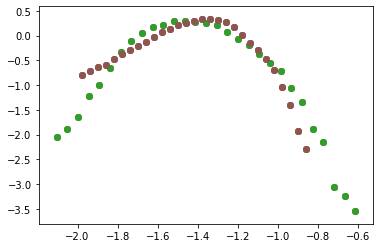

In [71]:
data_array_before_scaled = data_array_before / 1e24
data_array_after_scaled = data_array_after / 1e24
plotting_pdf(data_array_before_scaled, 30)
x_arr_before2 = plotting_pdf(data_array_before_scaled, 30)[0]
y_arr_before2 = plotting_pdf(data_array_before_scaled, 30)[1]
plotting_pdf(data_array_after_scaled, 30)
x_arr_after2 = plotting_pdf(data_array_after_scaled, 30)[0]
y_arr_after2 = plotting_pdf(data_array_after_scaled, 30)[1]

In [76]:
x = 10**(x_arr_before2)
y = np.nan_to_num(y_arr_before2[:-1])
true_sigman = 0.4
true_an = np.mean(x)
true_mun = 22
true_mp = -7
true_break = 22.9

In [77]:
print(x)

[0.00788145 0.00890815 0.01006859 0.0113802  0.01286267 0.01453826
 0.01643213 0.0185727  0.02099212 0.02372671 0.02681754 0.03031099
 0.03425953 0.03872244 0.04376672 0.0494681  0.05591219 0.06319574
 0.0714281  0.08073287 0.09124974 0.10313663 0.11657199 0.13175754
 0.14892128 0.16832089 0.19024765 0.21503076 0.2430423 ]


In [82]:
print(y)

[-2.050877   -1.87948086 -1.6391487  -1.21385909 -0.99941326 -0.65014409
 -0.34084156 -0.11932071  0.04915986  0.16720088  0.21652185  0.28571184
  0.29547598  0.27842245  0.25364133  0.20888638  0.06628734 -0.06613197
 -0.19922419 -0.37640106 -0.54880246 -0.72072516 -1.050877   -1.33272367
 -1.88902618 -2.14429868 -3.06511743 -3.24120869 -3.54223869]


In [81]:
model_obj = lmfit.Model(lognorm_powerlaw_func)
result = model_obj.fit(y,x=x,an=np.mean(x),mun=-1.4,sigman=0.3,mp=-6,pbreak=10**(-1.1))
uncs = result.eval_uncertainty()

fit_x0 = result.params['pbreak'].value
fit_an = result.params['an'].value
fit_mun = result.params['mun'].value
fit_sigman = result.params['sigman'].value
fit_mp = result.params['mp'].value
fit_pbreak = result.params['pbreak'].value

print(result.fit_report())
result.params['mp'].value

ValueError: The model function generated NaN values and the fit aborted! Please check your model function and/or set boundaries on parameters where applicable. In cases like this, using "nan_policy='omit'" will probably not work.